### Exploratory Data Analysis (EDA) for Daily SLIE GeoTIFFs

This notebook executes EDA for the daily SLIE landfast sea ice data for both the Chukchi Sea and the Beaufort Sea ice zones. For each zone and ice year a sample of the data will be plotted and metadata will be tested for consistency. We will examine file counts for each zone and the associated date information encoded in the file names as well.

In [1]:
from pathlib import Path

import rasterio as rio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors

from rasterio.warp import Resampling, aligned_target
from rasterio.transform import array_bounds
from rasterio.merge import merge

import eda as eda
from luts import ice_zones, ice_years, pixel_values
from config import INPUT_DIR, SCRATCH_DIR

In [2]:
pixel_values

{0: 'Not Landfast Ice',
 32: 'Coast Vector Shadow',
 64: 'Out of Bounds',
 111: 'No Data',
 128: 'Land',
 255: 'Landfast Ice'}

In [3]:
daily_slie_paths = []
for region in ice_zones:
    for year in ice_years:
        daily_slie_paths.append(Path(INPUT_DIR / region / year))

In [4]:
chuk_dates = []
beauf_dates = []
for directory in daily_slie_paths:

    geotiff_dates = eda.get_dates(directory)
    if "Chuk" in directory.parent.name:
        chuk_dates = chuk_dates + geotiff_dates
    elif "Beau" in directory.parent.name:
        beauf_dates = beauf_dates + geotiff_dates
    else:
        print(directory.parent.name)

print(f"There are {len(beauf_dates)} dates in the Beaufort time series.")
print(f"There are {len(chuk_dates)} dates in the Chukchi time series.")

dates_in_beaufort_not_in_chukchi = list(set(beauf_dates) - set(chuk_dates))
print(f"There are {len(dates_in_beaufort_not_in_chukchi)} dates in the Beaufort time series that are not in the Chukchi time series.")

time_index = pd.to_datetime(dates_in_beaufort_not_in_chukchi)
missing_dates = time_index.sort_values()
missing_dates.to_series().to_csv(SCRATCH_DIR / "dates_in_beau_but_not_in_chuk.csv", index=False)

There are 7797 dates in the Beaufort time series.
There are 7668 dates in the Chukchi time series.
There are 160 dates in the Beaufort time series that are not in the Chukchi time series.


There are 160 dates for which the Beaufort region has data, but the Chukchi region does not (i.e., there are no GeoTIFF files for those dates).
Most of the "missing" dates are in July and all of them are within the 1997-2008 period.

Awaiting PI confirmation regarding whether or not this is a known and expected difference in observing capabilities between the two regions vs. being an unintentional data gap. Unless we hear otherwise, will proceed under the assumption that these dates simply did not have a valid landfast sea ice detection and no GeoTIFF files were created.

In [5]:
for directory in daily_slie_paths:
    eda.test_geotiff_metadata_for_conformity(directory, geotiff_metadata=None, str_to_match="dailyslie")

All GeoTIFF metadata in /beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/1996-97 is identical.
All GeoTIFF metadata in /beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/1997-98 is identical.
All GeoTIFF metadata in /beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/1998-99 is identical.
All GeoTIFF metadata in /beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/1999-00 is identical.
All GeoTIFF metadata in /beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/2000-01 is identical.
All GeoTIFF metadata in /beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/2001-02 is identical.
All GeoTIFF metadata in /beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/2002-03 is identical.
All GeoTIFF metadata in /beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/2003-04 is identical.
All GeoTIFF metadata in /beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/2004-05 is identical.
All GeoTIFF metadata in /beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/2005-06 is identical.
All GeoTIFF metadata in /beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/2006-07 is identical.
All GeoTIFF metadata 

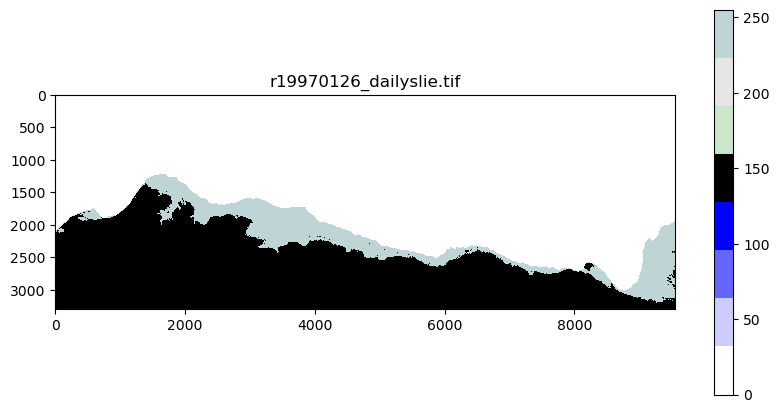

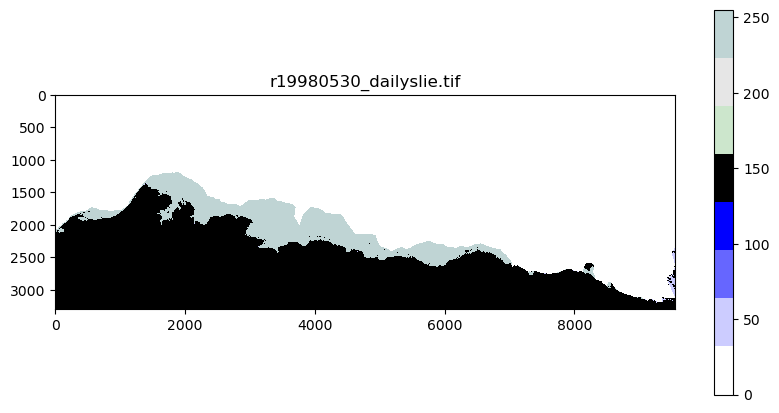

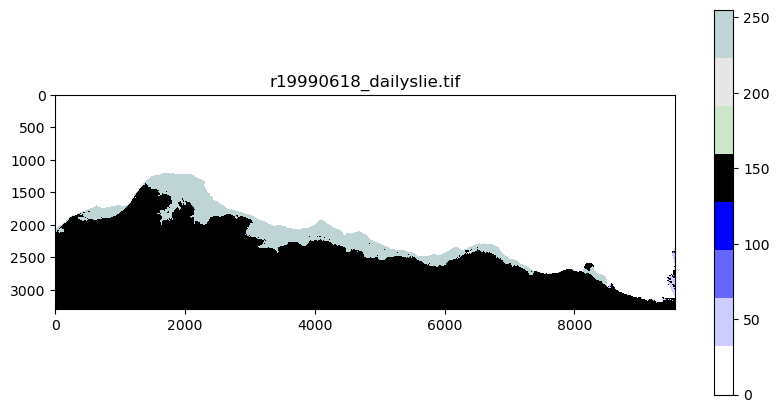

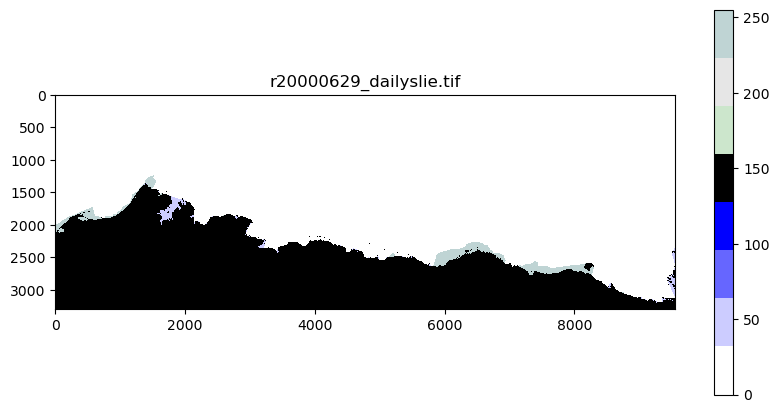

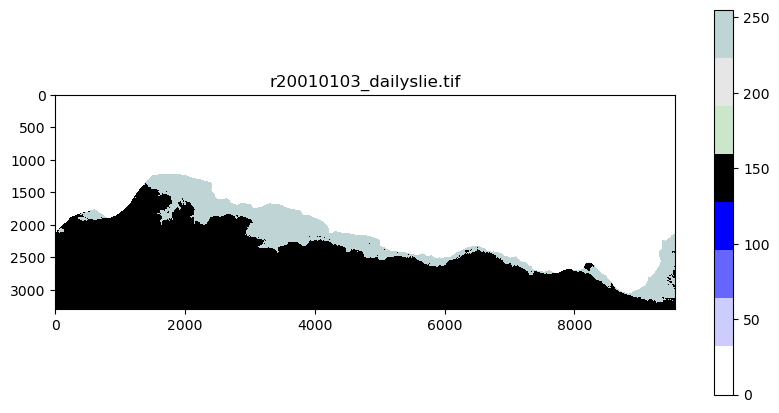

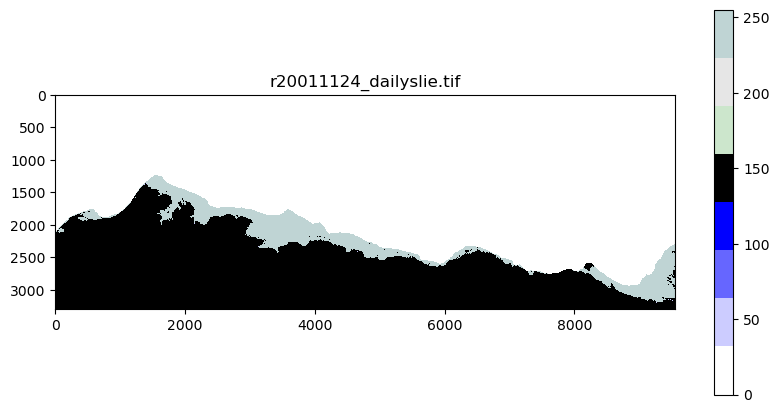

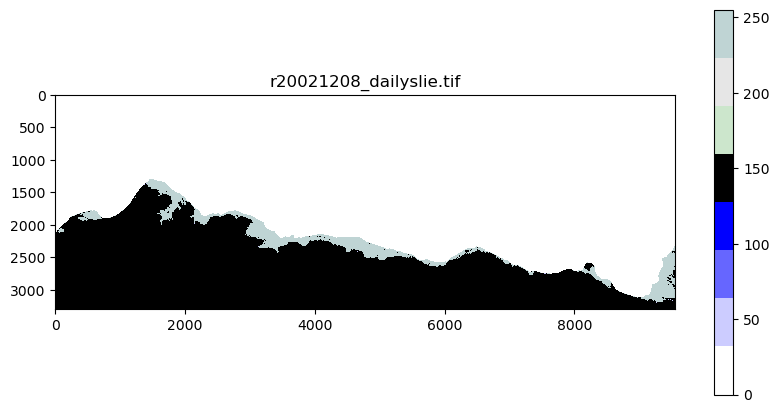

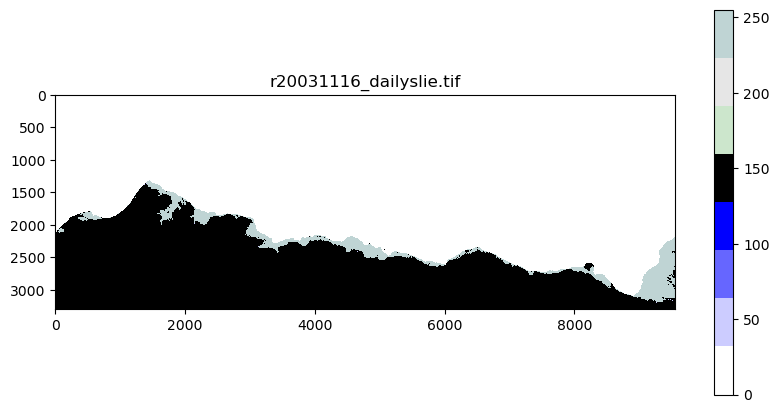

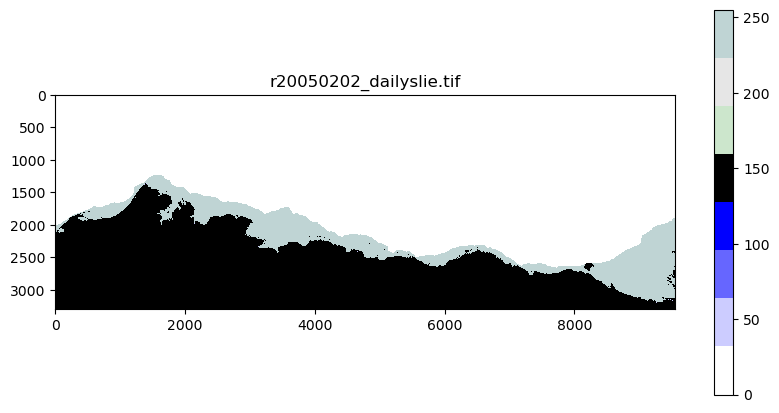

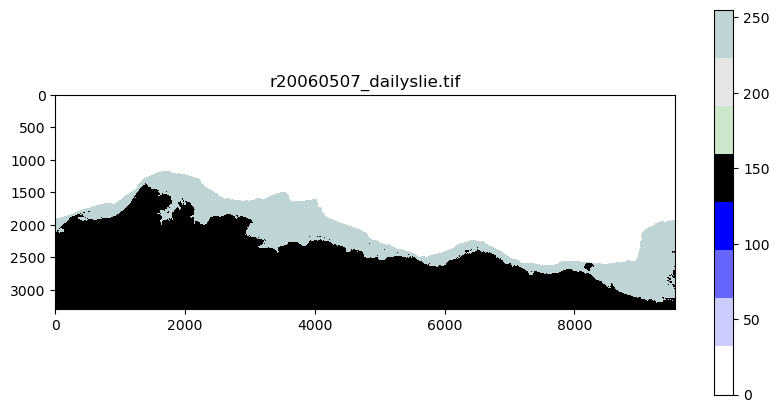

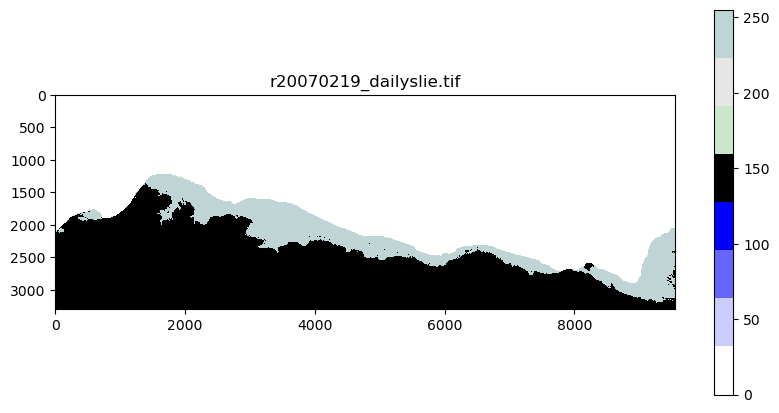

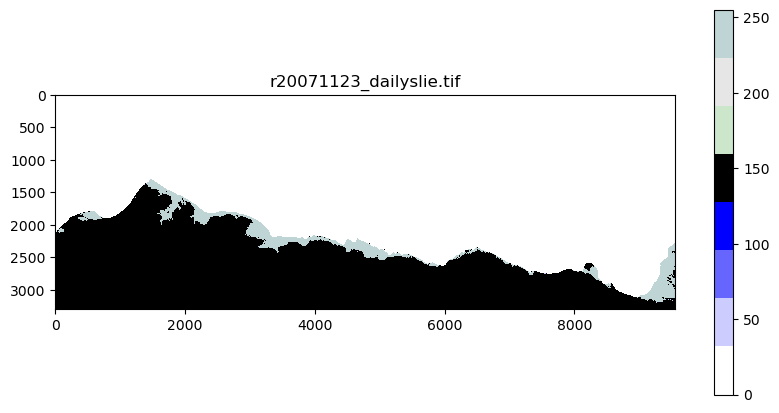

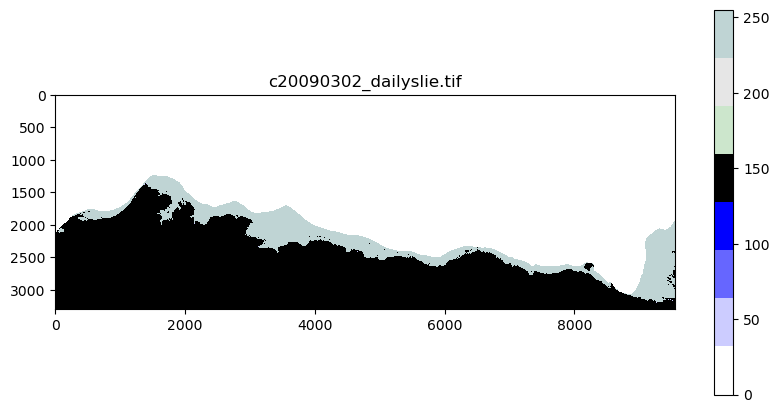

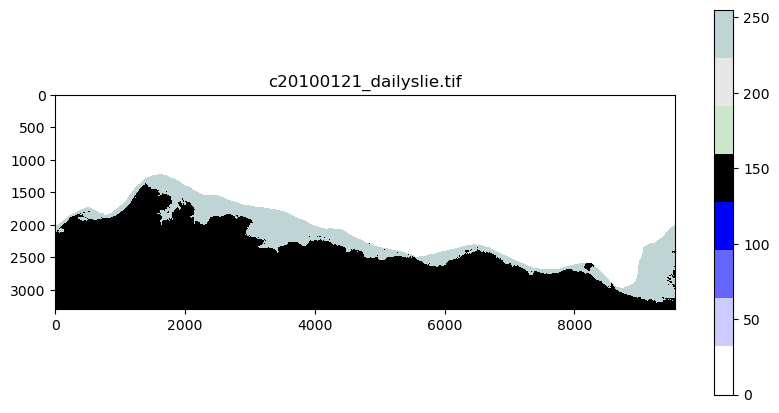

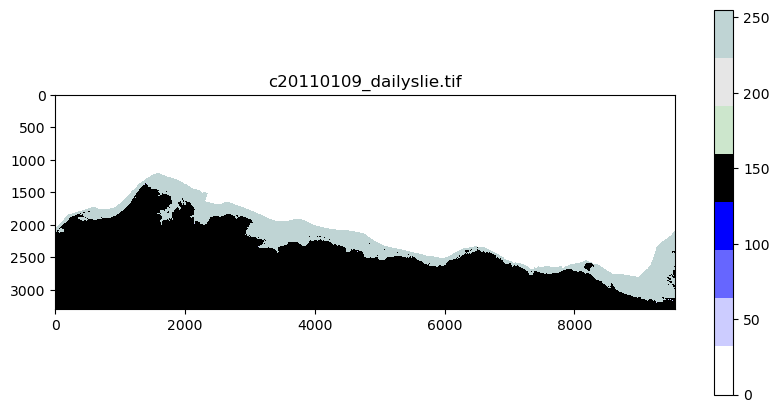

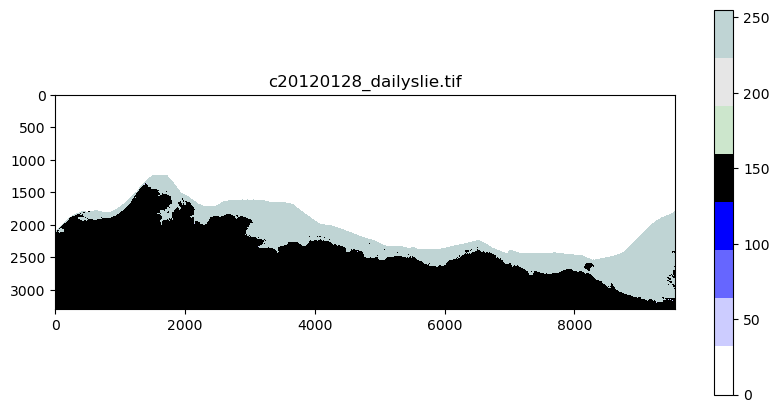

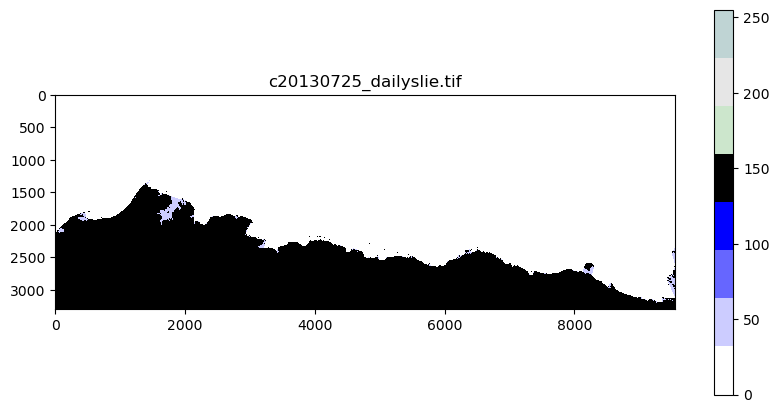

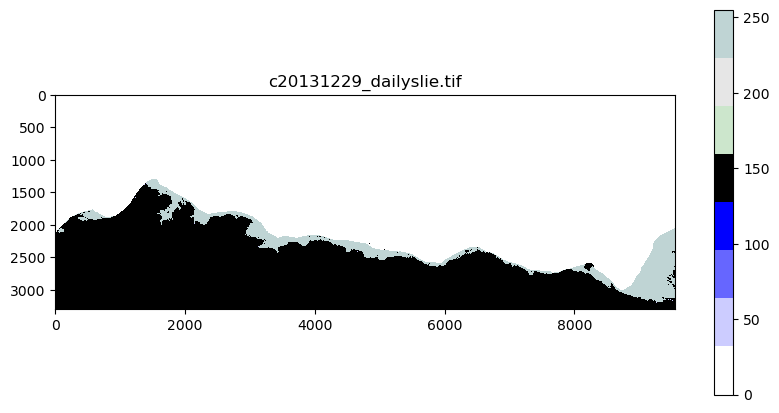

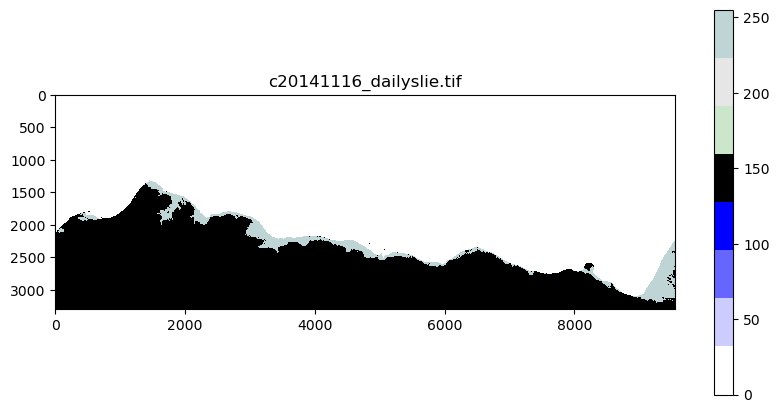

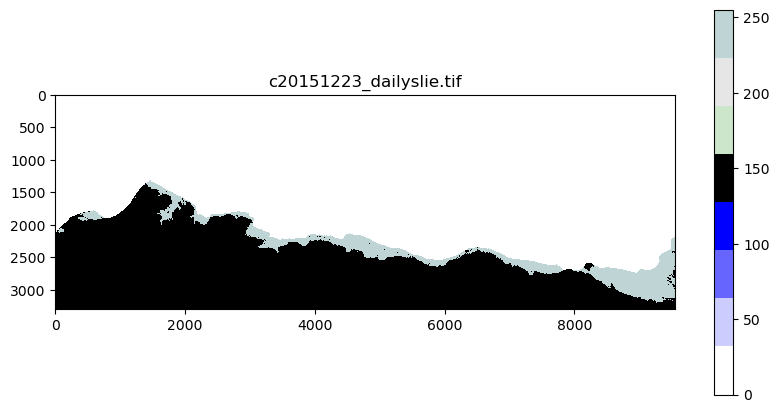

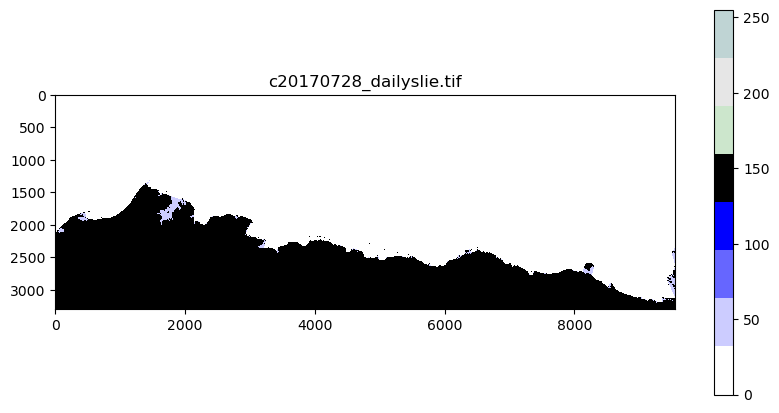

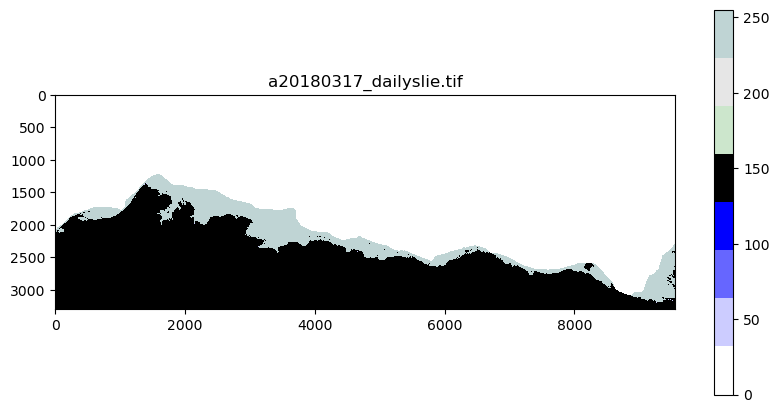

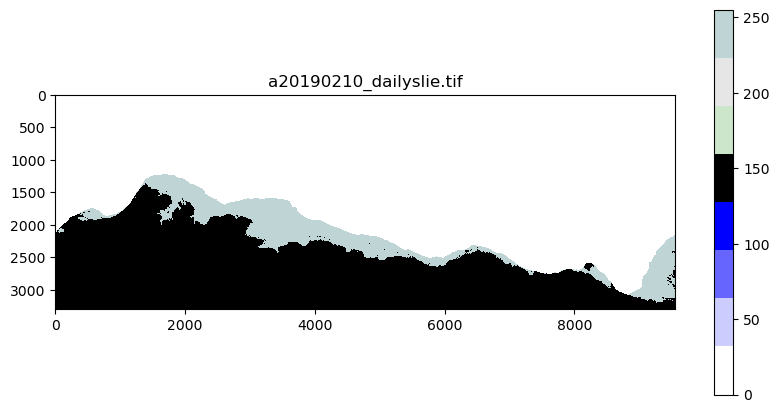

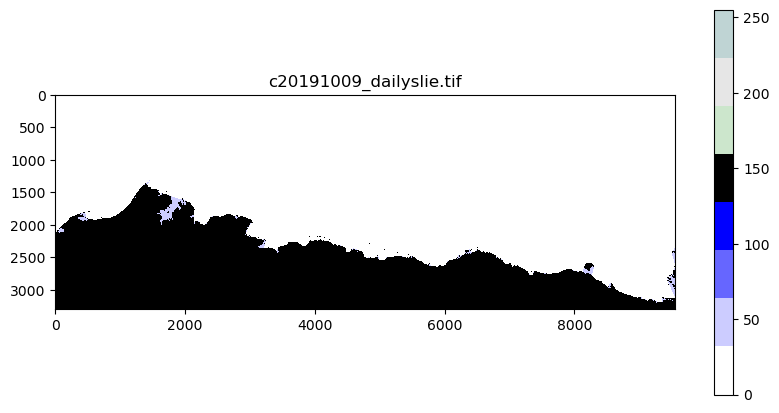

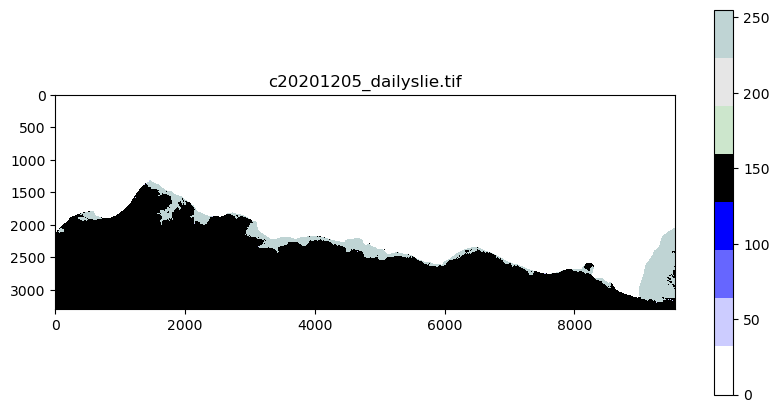

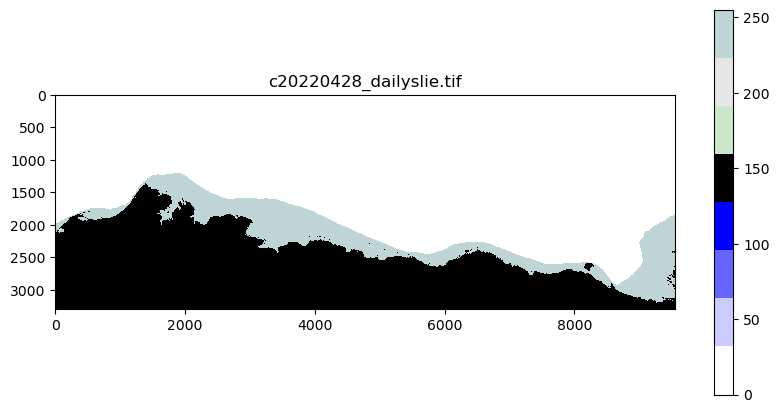

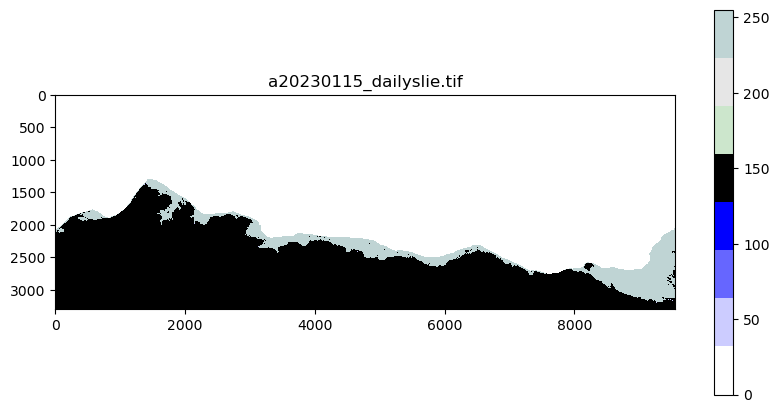

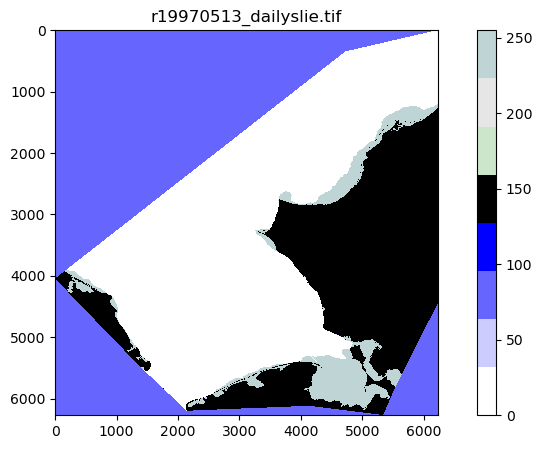

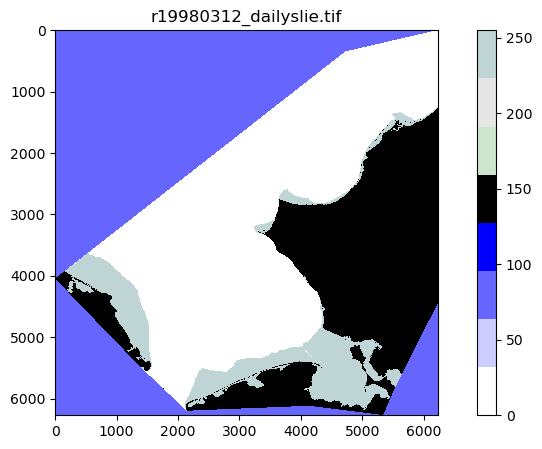

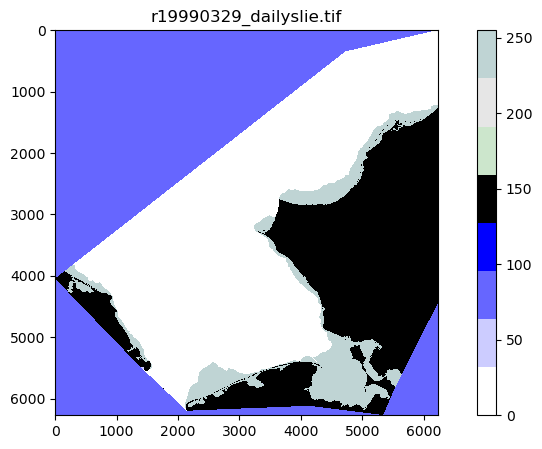

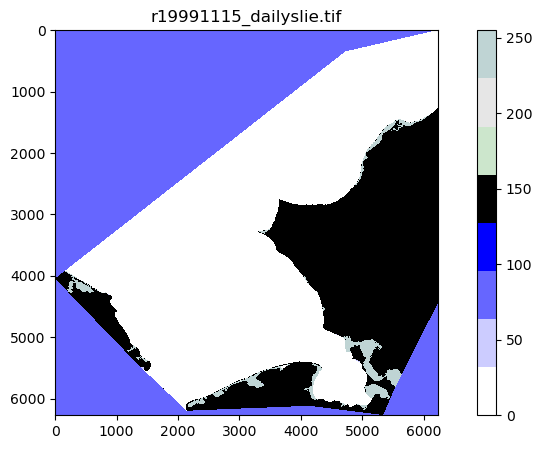

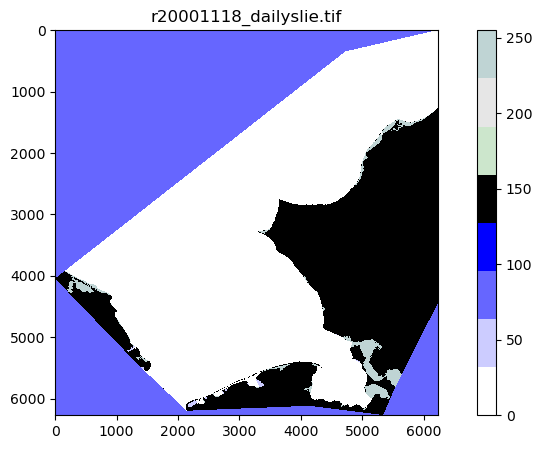

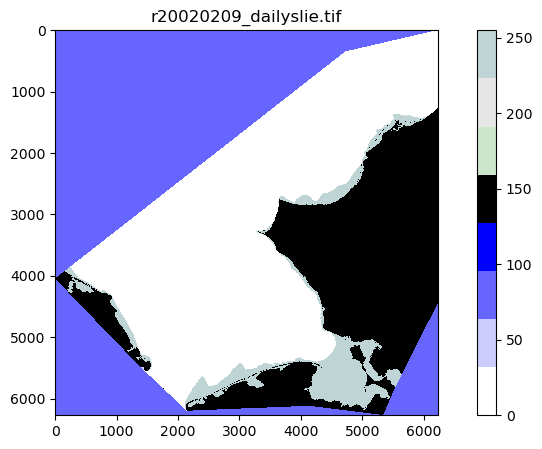

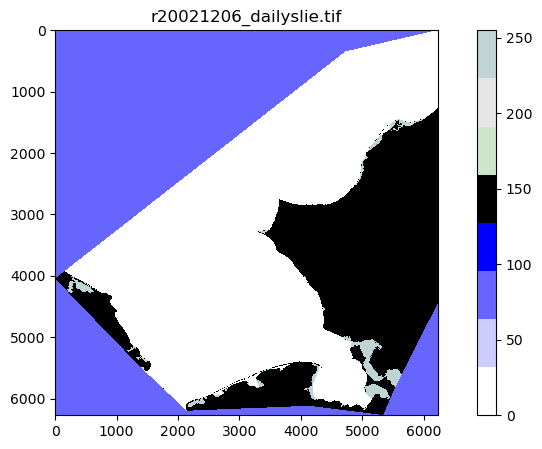

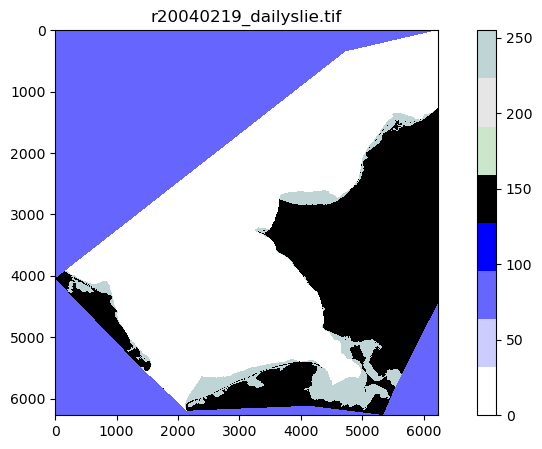

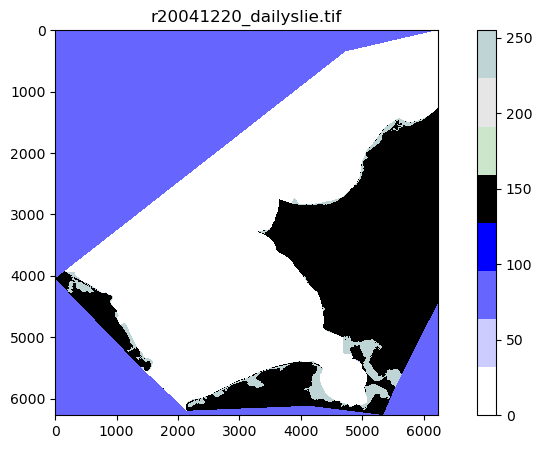

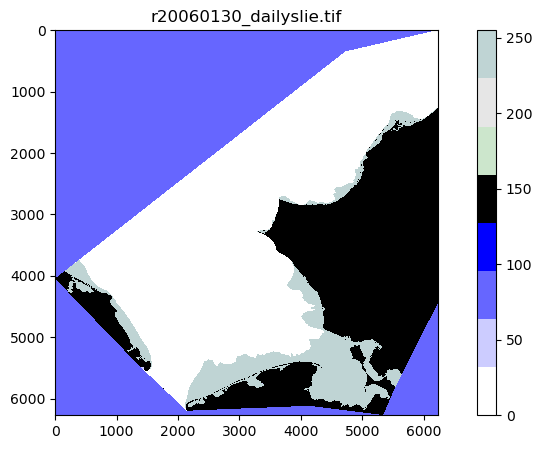

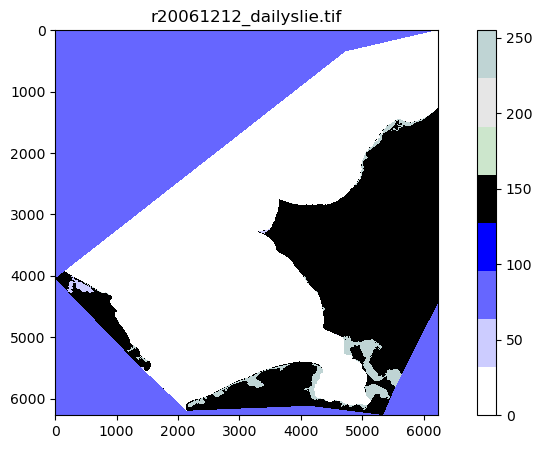

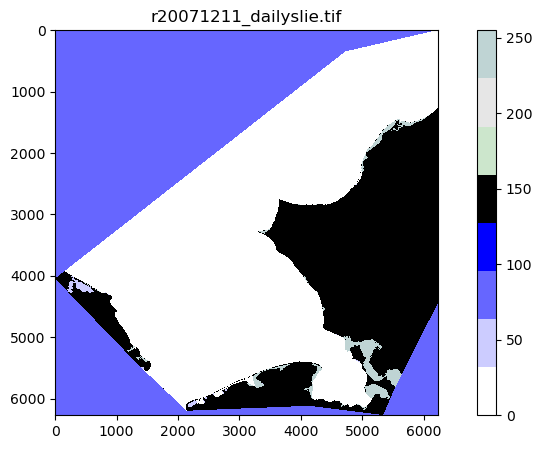

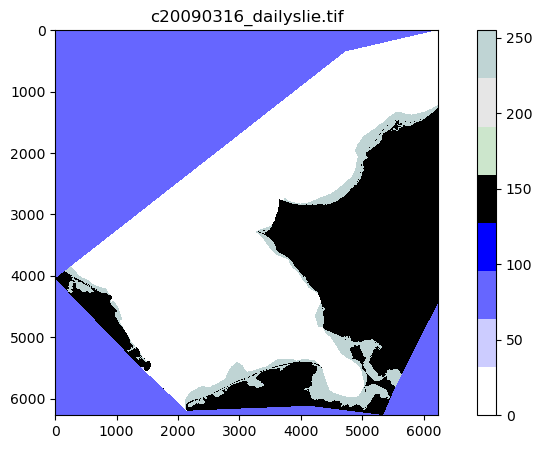

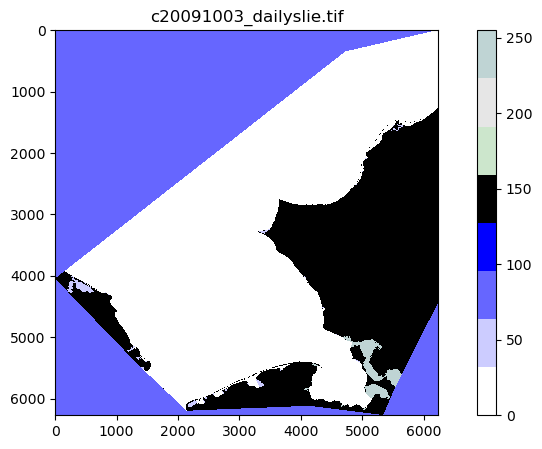

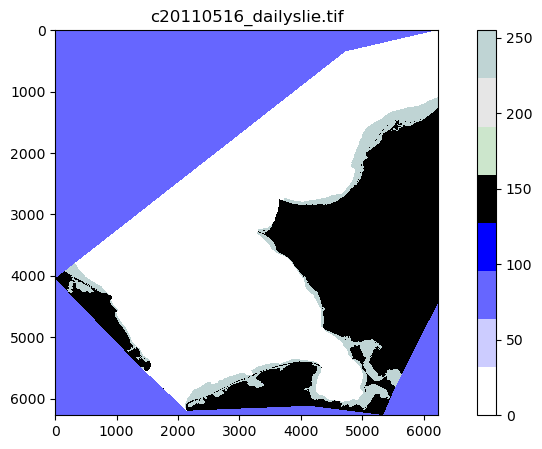

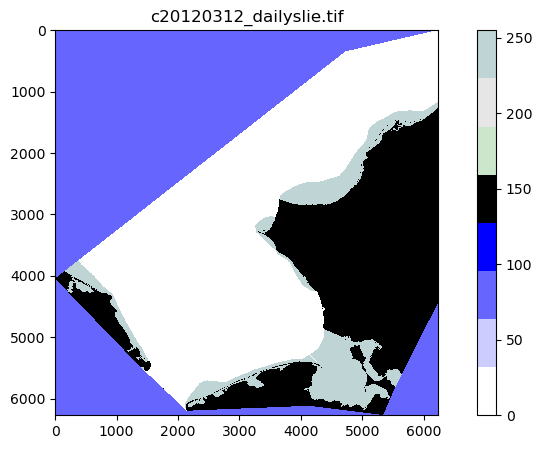

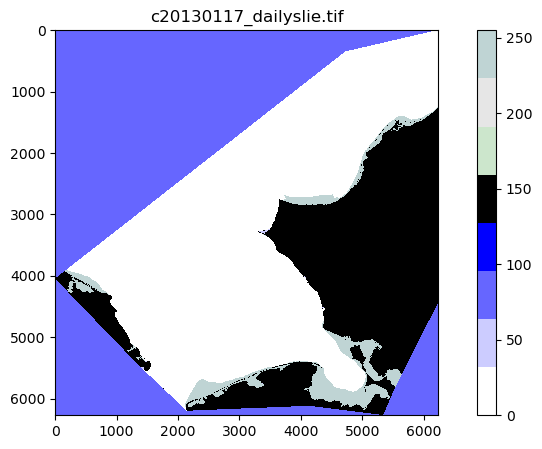

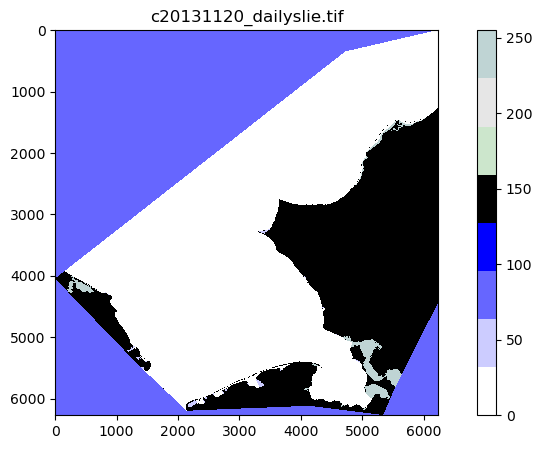

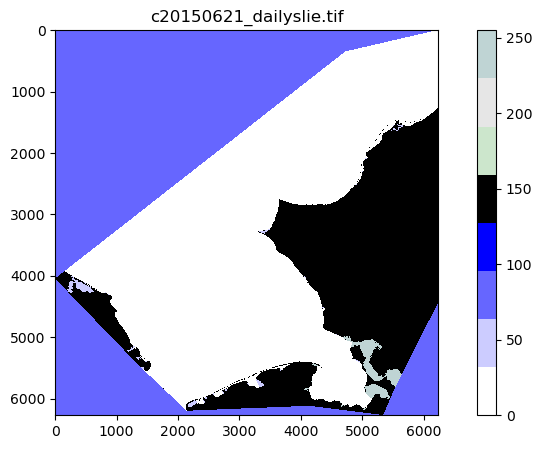

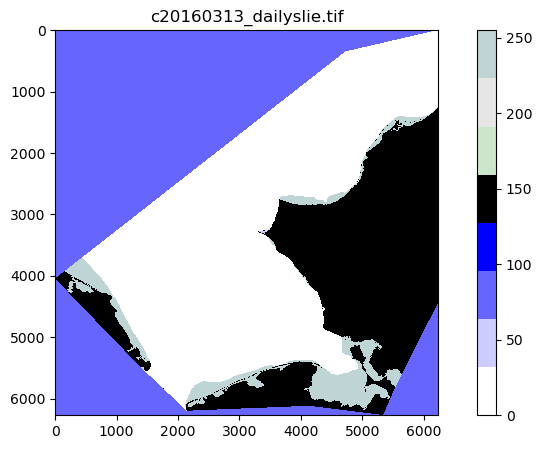

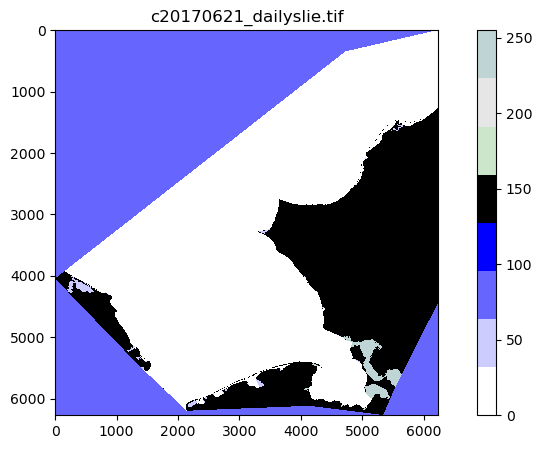

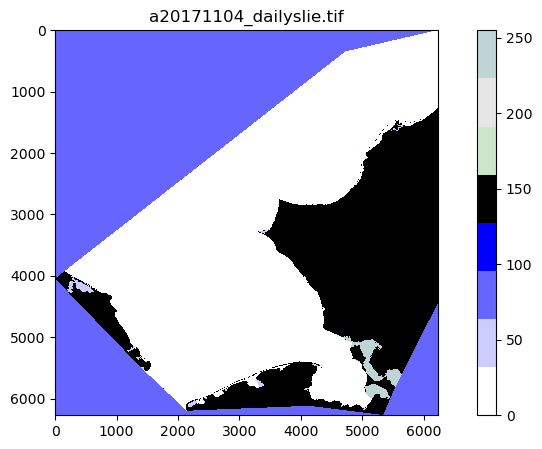

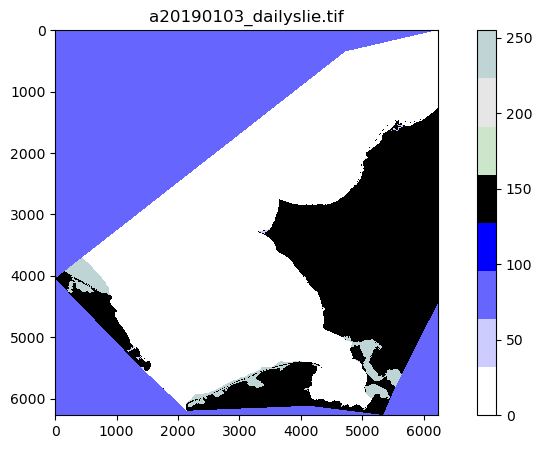

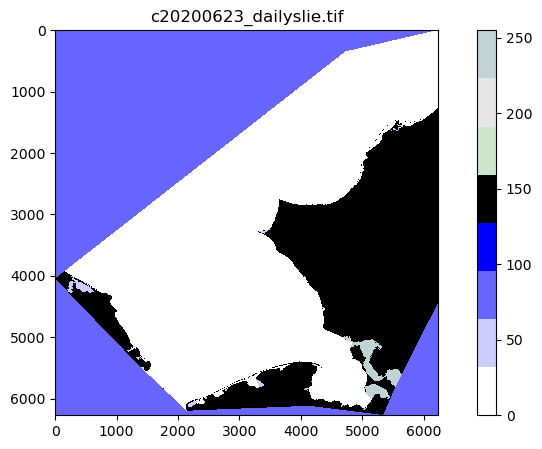

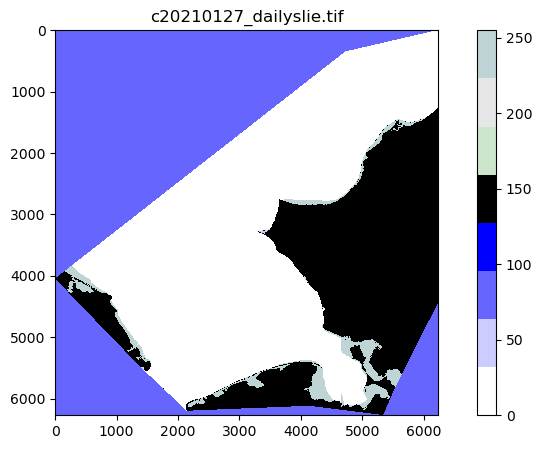

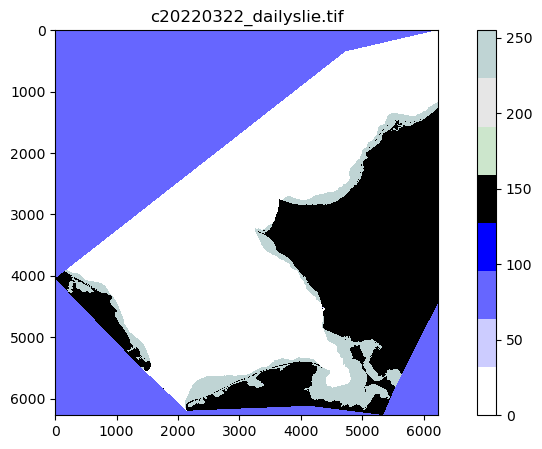

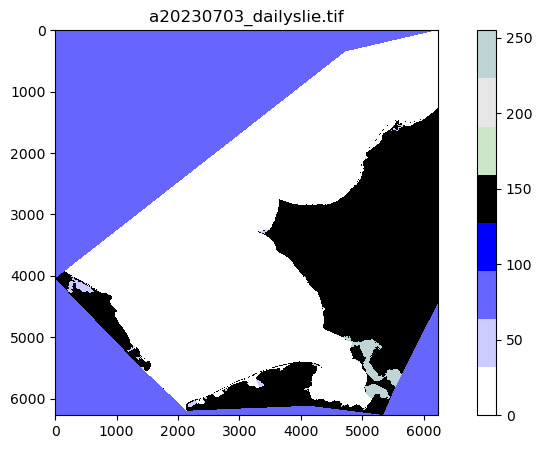

In [7]:
for directory in daily_slie_paths:
    eda.plot_random_sample(directory)

So far so good - there is constant metadata within each directory, and the data pass the eyeball test, at least for the random sample plotted here.
The next step is to determine how we might reproject these data. The Beaufort and Chukchi ice zones are geographically adjacent, but not quite contiguous, and together encompass Alaska's Arctic coastline - but how the data products precisely line up is unknown. We can test this by running a stock `merge` command on the data and looking at the outputs. We'll also examine the metadata of the original products.

In [6]:
chuk_sample = INPUT_DIR/"Chuk/2022-23/a20221201_dailyslie.tif"
beauf_sample = INPUT_DIR/"Beau/2022-23/a20221201_dailyslie.tif"

with rio.open(beauf_sample) as src:
    print("Original Beaufort Meta")
    print(src.profile)

with rio.open(chuk_sample) as src:
    print("Original Chukchi Meta")
    print(src.profile)

# merge order matters, reverse painter's algorithm is the default ordering used by rasterio.merge.merge
# so we will look at both cases
beau_overlay_chuk, aff_ = merge([chuk_sample, beauf_sample])
chuk_overlay_beauf, aff2_ = merge([beauf_sample, chuk_sample])

Original Beaufort Meta
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 9554, 'height': 3298, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",50],PARAMETER["longitude_of_center",-154],PARAMETER["standard_parallel_1",55],PARAMETER["standard_parallel_2",65],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(100.0, 0.0, -236180.0,
       0.0, -100.0, 2509919.0), 'blockxsize': 960, 'blockysize': 336, 'tiled': True, 'compress': 'packbits', 'interleave': 'band'}
Original Chukchi Meta
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 6234, 'height': 6271

There are a few things to point out in the metadata:

**'nodata': None** is a bit unusual. We'll want to set this to `111` per the PI documentation. This should reduce the file size as well.

**AUTHORITY["EPSG","4326"]]** - we'll want to reproject these data to EPSG 3338

**Affine(100.0, 0.0, -236180.0, 0.0, -100.0, 2509919.0)** these data have 100 m resolution - this is expected, but a far finer spatial resolution than we usually work with

**'compress': 'packbits'** not a common compression algorithm in my experience, we'll consider alternatives

**'transform': Affine(100.0, 0.0, -859401.4481000006, 0.0, -100.0, 2423189.104800001)** - the Chukchi affine transformation has some floating point noise. We can trim this by reprojecting with a `target aligned pixels` parameter.

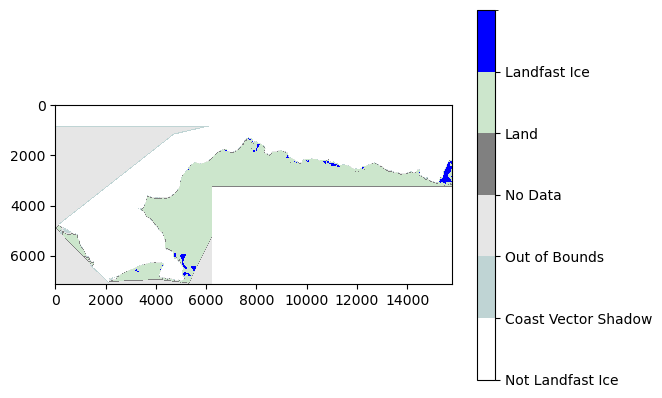

In [7]:
eda.plot_daily_slie_array(beau_overlay_chuk[0])

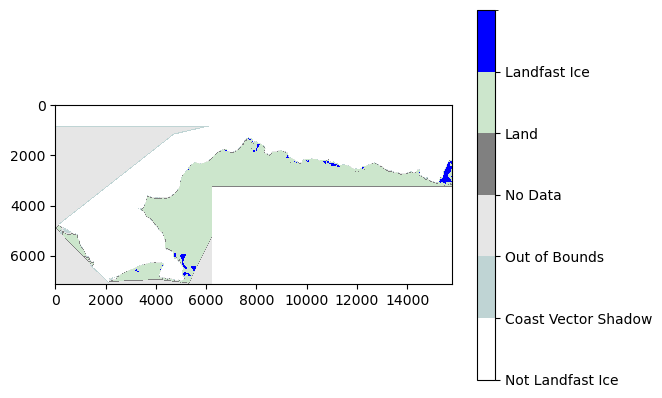

In [8]:
eda.plot_daily_slie_array(chuk_overlay_beauf[0])

The full extent of both merge products seems good - but upon closer inspection there is an unsightly seam where the two data products meet.

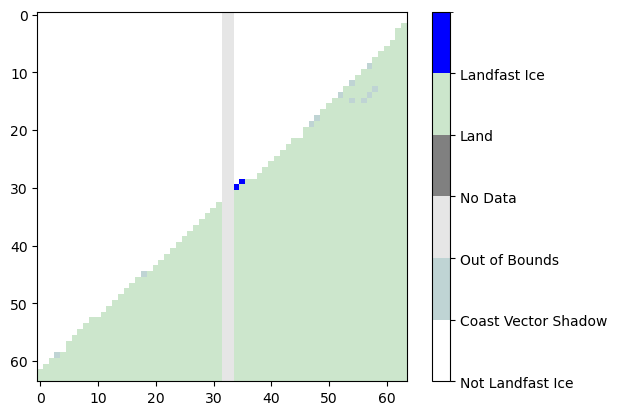

In [9]:
eda.plot_daily_slie_array(beau_overlay_chuk[0, 2100:2164, 6200:6264])

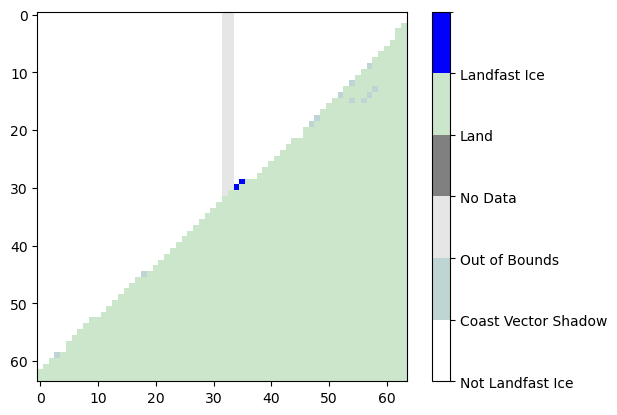

In [10]:
eda.plot_daily_slie_array(chuk_overlay_beauf[0, 2100:2164, 6200:6264])

So, there are two initial reasons to avoid merging these products. First, in the large scale view in the first set of plots from the merged products we learn that merging the two geographic regions creates a raster where the vast majority of the pixels are "NoData" - unfortunately Alaska's Arctic Coastline does not conform to a shape conducive to efficient use of a 2-D array. And this is expensive when the pixel size is 100 m.

Second, there is a seam of discontinuity between the two zones. While we can tell that the terrestrial integrity of the merged product improves when the Chukchi data overlays the Beaufort, rather than vice-versa, there is still a marine "No Data" strip. Ultimately, this is fine. These were discrete datasets from the beginning, and the PIs gave no indication that they should be merged.

However, if a seamless, merged data product were desired we could shift the bounds of one of these datasets in reprojection to eliminate the seam. We could "bump" the Chukchi dataset 200 m (these are 100 m pixels, and that seam appears to be about two pixels) to the East and eliminate the seam in the overlay using a `target aligned pixels` aka `tap` GDAL-esque method combined with a prescribed offset when we reproject these data. We will use the `tap` method either way to eliminate the floating point noise in the Chukchi affine transformation. We also know that `111` is the no data value for this dataset, so let's go ahead and prescribe that in the raster creation profile for all cases. We'll do some experimentation in the following cells.

In [11]:
def test_tap_reproject_raster(file):
    """Throw-away function to test some reprojection params"""
    tr = 100
    dst_crs = rio.crs.CRS.from_epsg(3338)
    with rio.open(file) as src:
        # compute the new affine transformation, width and height
        warp_transform, width, height = rio.warp.calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds, resolution=(tr, tr)
        )        
        tap_transform, tap_width, tap_height = aligned_target(
            warp_transform, width, height, tr
        )
        
        out_profile = src.profile.copy()
        out_profile.update(
            {
                "crs": dst_crs,
                "transform": tap_transform,
                "width": tap_width,
                "height": tap_height,
                "bounds": array_bounds(tap_height, tap_width, tap_transform),
                "nodata": 111,
                "compress": "lzw",
            }
        )
        
        out_file = SCRATCH_DIR / f"reproj_tap_{file.parent.parent.name}_{file.name}"
        print(f"Creating {out_file} with raster profile {out_profile}")
        with rio.open(out_file, "w", **out_profile) as dst:
            # reproject the input raster data
            rio.warp.reproject(
                source=src.read(1),
                destination=rio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=tap_transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest,  # NN is default, but explicit here for easy change or experimentation later
            )

test_tap_reproject_raster(chuk_sample)
test_tap_reproject_raster(beauf_sample)
tap_chuk_sample = SCRATCH_DIR / f"reproj_tap_{chuk_sample.parent.parent.name}_{chuk_sample.name}"
tap_beauf_sample = SCRATCH_DIR / f"reproj_tap_{beauf_sample.parent.parent.name}_{beauf_sample.name}"

with rio.open(tap_beauf_sample) as src:
    print("Beaufort Meta")
    print(src.profile)
    
with rio.open(tap_chuk_sample) as src:
    print("Chukchi Meta")
    print(src.profile)

Creating /beegfs/CMIP6/cparr4/landfast_sea_ice_scratch/reproj_tap_Chuk_a20221201_dailyslie.tif with raster profile {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 111, 'width': 6235, 'height': 6272, 'count': 1, 'crs': CRS.from_epsg(3338), 'transform': Affine(100.0, 0.0, -859500.0,
       0.0, -100.0, 2423200.0), 'blockxsize': 624, 'blockysize': 640, 'tiled': True, 'compress': 'lzw', 'interleave': 'band', 'bounds': (-859500.0, 1796000.0, -236000.0, 2423200.0)}
Creating /beegfs/CMIP6/cparr4/landfast_sea_ice_scratch/reproj_tap_Beau_a20221201_dailyslie.tif with raster profile {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 111, 'width': 9556, 'height': 3300, 'count': 1, 'crs': CRS.from_epsg(3338), 'transform': Affine(100.0, 0.0, -236200.0,
       0.0, -100.0, 2510000.0), 'blockxsize': 960, 'blockysize': 336, 'tiled': True, 'compress': 'lzw', 'interleave': 'band', 'bounds': (-236200.0, 2180000.0, 719400.0, 2510000.0)}
Beaufort Meta
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 111.0, 'wid

We've fixed the floating pointnoise, the nodata value, and the compression. Let's look and see if the merged product changed at all, out of curiousity.

In [12]:
reproj_tap_chuk_overlay_beauf, _ = merge([tap_beauf_sample, tap_chuk_sample])
reproj_tap_beauf_overlay_chuk, _ = merge([tap_chuk_sample, tap_beauf_sample])
slice_chuk = reproj_tap_chuk_overlay_beauf[0, 2100:2164, 6200:6264]
slice_beauf = reproj_tap_beauf_overlay_chuk[0, 2100:2164, 6200:6264]
unique_chuk, counts_chuk = np.unique(slice_chuk, return_counts=True)
unique_beauf, counts_beauf = np.unique(slice_beauf, return_counts=True)

/tmp/ipykernel_2818855/675201995.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  set1_cmap = get_cmap("Set1", num_colors)


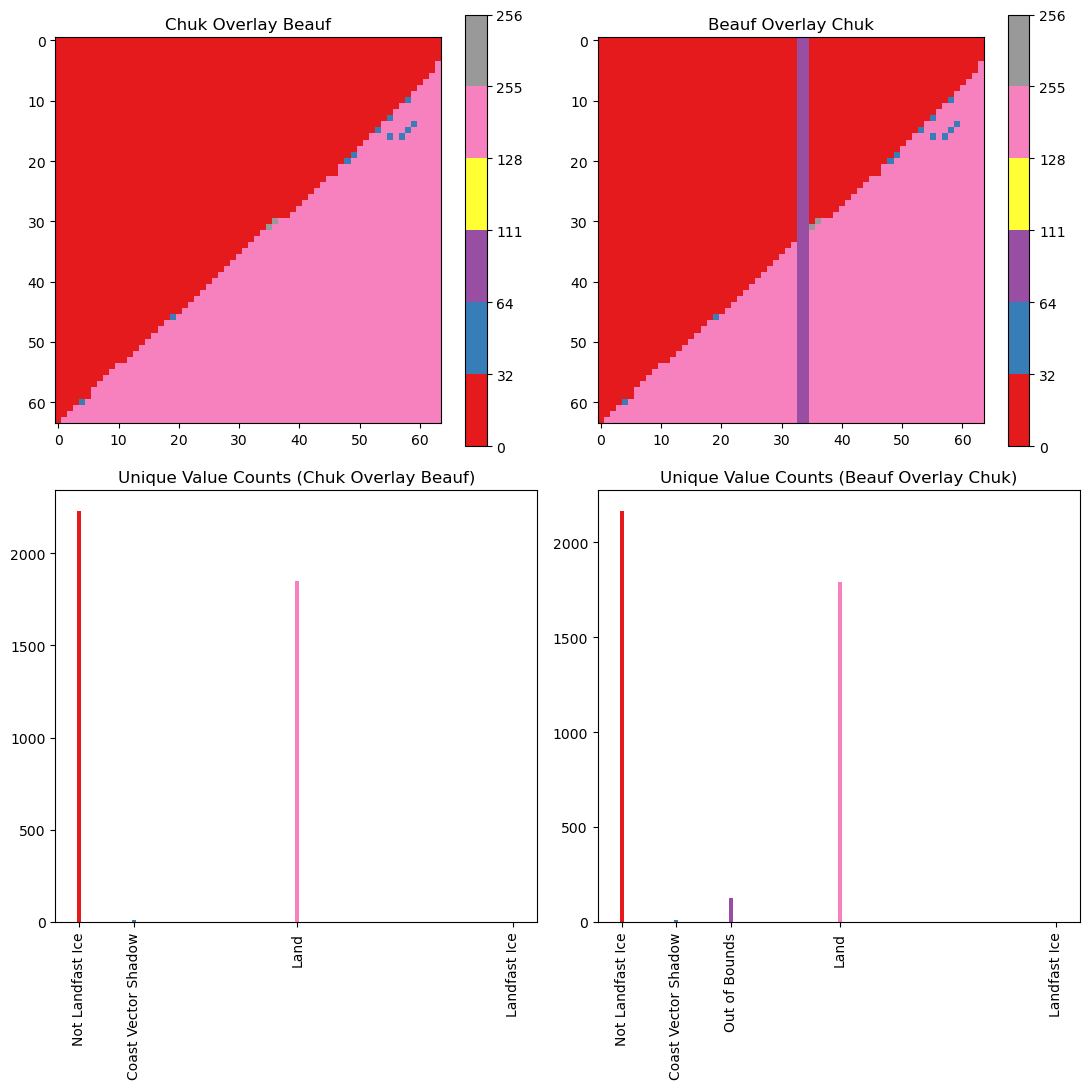

In [13]:
from matplotlib.cm import get_cmap

# Create a colormap from "Set1" limited to the number of keys in pixel_values
num_colors = len(pixel_values)
set1_cmap = get_cmap("Set1", num_colors)
colors = set1_cmap(np.arange(num_colors))
cmap = mcolors.ListedColormap(colors)
bounds = list(pixel_values.keys())
norm = mcolors.BoundaryNorm(bounds + [max(bounds) + 1], cmap.N)

# Create the plot
fig, axs = plt.subplots(2, 2, figsize=(11, 11))
im1 = axs[0, 0].imshow(slice_chuk, cmap=cmap, norm=norm)
fig.colorbar(im1, ax=axs[0, 0])
axs[0, 0].set_title('Chuk Overlay Beauf')
im2 = axs[0, 1].imshow(slice_beauf, cmap=cmap, norm=norm)
fig.colorbar(im2, ax=axs[0, 1])
axs[0, 1].set_title('Beauf Overlay Chuk')

# Bottom row: bar charts of unique value counts
bar_width = 2.5  # Make the bars fatter
colors_chuk = [colors[bounds.index(val)] for val in unique_chuk]
colors_beauf = [colors[bounds.index(val)] for val in unique_beauf]

axs[1, 0].bar(unique_chuk, counts_chuk, color=colors_chuk, width=bar_width)
axs[1, 0].set_xticks(unique_chuk)
axs[1, 0].set_xticklabels([pixel_values.get(val, str(val)) for val in unique_chuk], rotation=90)
axs[1, 0].set_title('Unique Value Counts (Chuk Overlay Beauf)')

axs[1, 1].bar(unique_beauf, counts_beauf, color=colors_beauf, width=bar_width)
axs[1, 1].set_xticks(unique_beauf)
axs[1, 1].set_xticklabels([pixel_values.get(val, str(val)) for val in unique_beauf], rotation=90)
axs[1, 1].set_title('Unique Value Counts (Beauf Overlay Chuk)')

plt.tight_layout()
plt.show()

Well, we can see that the results of the default tap really didn't have much of an impact. That makes sense if you compare the metadata, we only bumped things like one meter. We will conclude the EDA here, we have enough information to proceed with constructing some preprocessing functions to use to generate our desired dataset.